# Tune the model

Steps:
1. tune scavenging rate constant based on residence time
2. tune sediment resuspension based on observed Pb profiles
3. tune sediment content in ice based on observed Pb profiles


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr
import cmocean
import pandas as pd 
import forcing.modules.mapping_functions as mf
import seaborn as sns
import glob
from datetime import datetime

%matplotlib inline

#### Parameters:

In [2]:
# domain dimensions:
jmin, jmax = 159, 799
imin, imax = 1139, 2179

isize = imax-imin
jsize = jmax-jmin

# results to plot:
year    = 2002
month   = 8
folder1 = '/data/brogalla/run_storage/Pb-new-ini2-spin1/'

# colours:
land_color     = '#a9a7a2'
profile_colors = ['#ff4949', '#01b9ff']

#### Files:

Model results

In [3]:
# file1 = f'ANHA12_EXH006_{year}_monthly.nc'
file1        = 'ANHA12_EXH006_5d_20020101_20021231_ptrc_T_20021222-20021226.nc'
d

Mesh

In [4]:
mfile        = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/ANHA12/ANHA12_mask_Pb-20220317.nc')
mesh_lon     = mfile['nav_lon'].values
mesh_lat     = mfile['nav_lat'].values
tmask        = mfile['tmask'].values[0,:,imin:imax,jmin:jmax]
bathy_masked = np.ma.masked_where((tmask> 0.1), tmask) 
mesh_depth   = mfile['nav_lev'].values

In [8]:
tmask.shape

(50, 1040, 640)

Observations

In [5]:
# Station coordinates and names:
stn_n = np.array(['BB1', 'BB2', 'BB3', 'CAA1', 'CAA2', 'CAA3', 'CAA4', 'CAA5', 'CAA6', 'CAA7', 'CAA8', 'CAA9', \
          'CB1', 'CB2', 'CB3', 'CB4'])
stn_i = np.array([174, 337, 316, 444, 440, 431, 515, 515, 573, 554, 692, 582, 798, 848, 887, 969])
stn_j = np.array([405, 415, 382, 370, 365, 353, 311, 326, 313, 281, 281, 364, 332, 384, 457, 471])

# Dissolved trace metal observations
Pb_data = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Pb-paper-data.csv')

Pb_data = Pb_data.rename(columns={"Depth.1": "Depth BB1", "Depth.2": "Depth BB2", "Depth.3": "Depth BB3", \
                        "Depth.4": "Depth CAA1", "Depth.5": "Depth CAA2", "Depth.6": "Depth CAA3", \
                        "Depth.7": "Depth CAA4", "Depth.8": "Depth CAA5", "Depth.9": "Depth CAA6", \
                        "Depth.10": "Depth CAA7", "Depth.11": "Depth CAA8", "Depth.12": "Depth CAA9", \
                        "Depth.13": "Depth CB1", "Depth.14": "Depth CB2", "Depth.15": "Depth CB3", \
                        "Depth.16": "Depth CB4"})

Pb_data[f'Depth CAA1'].loc[6] = np.NaN; Pb_data[f'Depth CAA2'].loc[5]  = np.NaN;
Pb_data[f'Depth CAA2'].loc[6] = np.NaN; Pb_data[f'Depth CAA6'].loc[4]  = np.NaN;
Pb_data[f'Depth CAA8'].loc[8] = np.NaN; Pb_data[f'Depth CAA8'].loc[10] = np.NaN;
Pb_data[f'Depth CAA9'].loc[8] = np.NaN; 
Pb_data[f'Depth CB1'].loc[8]  = np.NaN;  Pb_data[f'Depth CB1'].loc[9]  = np.NaN;
Pb_data[f'Depth CB2'].loc[1]  = np.NaN;  Pb_data[f'Depth CB3'].loc[20] = np.NaN;
Pb_data[f'Depth CB4'].loc[11] = np.NaN; Pb_data[f'Depth CB4'].loc[22]  = np.NaN;

bottom_depths = [np.amax(Pb_data[f'Depth {stn}']) for stn in stn_n]

/home/brogalla/miniconda3/envs/parcels-julab/lib/python3.6/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [6]:
stn_names = Pb_data['Station names'].dropna().astype('str')
obs_lons  = Pb_data['station lon'].astype('float').dropna().values
obs_lats  = Pb_data['Station lat'].astype('float').dropna().values

#### Functions

In [11]:
def calculate_2015sept_average(folder):
    # Calculate average over data files during cruise period:
    # 2015 GEOTRACES: 9 August - 15 September
    files_2015      = np.sort(glob.glob(f'{folder}ANHA12_EXH006_5d_20020101_20021231*'))
    start_date_2015 = datetime.strptime(f'2002-08-09', '%Y-%m-%d')
    end_date_2015   = datetime.strptime(f'2002-09-15', '%Y-%m-%d')

    file_list_2015 = []
    for file in files_2015:
        if (datetime.strptime(file.split('/')[-1][42:50],'%Y%m%d') >= start_date_2015) & \
                    (datetime.strptime(file.split('/')[-1][51:59],'%Y%m%d') < end_date_2015):
            file_list_2015.append(file)

    dpb_2015 = np.zeros((50,isize,jsize))
    days = 0
    for file in file_list_2015:
        ds = xr.open_dataset(f"{file}")
        dpb_2015 = dpb_2015 + ds['dissolpb'].values[0,:,:,:]

    pb_dis_ref_2015 = dpb_2015 / len(file_list_2015)
    
    return pb_dis_ref_2015

In [19]:
def load_Pb_model_results(file):

    pfile  = xr.open_dataset(file)
    Pb_dis = pfile['dissolpb'].values[0,:,:,:]
        
    return Pb_dis

In [189]:
def match_model_obs(Pb_dis):  
    dpb_obs_match     = pd.DataFrame(columns=stn_n)
    depth_obs_match   = pd.DataFrame(columns=stn_n)
    dpb_model_match   = pd.DataFrame(columns=stn_n)
    depth_model_match = pd.DataFrame(columns=stn_n)
    
    # For each of the 2015 GEOTRACES stations:
    for n, name in enumerate(stn_n):
        # observations
        dpb_obs_stn       = Pb_data[name][np.isfinite(Pb_data[name])].astype('float').values*1e3
        depth_obs_stn     = Pb_data[f'Depth {name}'][np.isfinite(Pb_data[f'Depth {name}'])].astype('float').values
        
        # model results
        dpb_model_stn     = Pb_dis[:,stn_i[stn_n==name],stn_j[stn_n==name]]*1e12 # convert to pM
        depth_model       = mesh_depth
        dpb_model_stn[tmask[:,stn_i[stn_n==name],stn_j[stn_n==name]] < 0.1] = np.nan # mask land with NaNs
        
        # find model result at depth nearest to observations (no interpolation)
        dpb_model_arr    = np.empty((25)); depth_model_arr = np.empty((25));
        dpb_obs_arr      = np.empty((25)); depth_obs_arr   = np.empty((25));
        dpb_model_arr[:] = np.nan; depth_model_arr[:] = np.nan;
        dpb_obs_arr[:]   = np.nan; depth_obs_arr[:]   = np.nan;
        for d, depth_obs in enumerate(depth_obs_stn):
            # index of model grid point closest to observation:
            min_diff  = np.amin(np.abs(depth_model - depth_obs))
            # only try to match if there is a match within 50 m depth
            if min_diff < 50:
                ind_depth = np.argmin(np.abs(depth_model - depth_obs))
                dpb_model_arr[d]   = dpb_model_stn[ind_depth]
                depth_model_arr[d] = depth_model[ind_depth]
                dpb_obs_arr[d]   = dpb_obs_stn[d]
                depth_obs_arr[d] = depth_obs_stn[d]
            else:
                dpb_model_arr[d]   = np.nan
                depth_model_arr[d] = np.nan
                dpb_obs_arr[d]     = np.nan
                depth_obs_arr[d]   = np.nan
                
        # write model depth to data frame:
        dpb_obs_match[name]     = dpb_obs_arr
        depth_obs_match[name]   = depth_obs_arr
        dpb_model_match[name]   = dpb_model_arr
        depth_model_match[name] = depth_model_arr
        
    dpb_model_match[np.isnan(dpb_obs_match)]   = np.nan
    depth_model_match[np.isnan(dpb_obs_match)] = np.nan
    dpb_obs_match[np.isnan(dpb_model_match)]   = np.nan
    depth_obs_match[np.isnan(dpb_model_match)] = np.nan
        
    return depth_obs_match, dpb_obs_match, depth_model_match, dpb_model_match

In [178]:
folder     = '/data/brogalla/run_storage/Pb-new-ini2-spin1/'
dpb_200209 = load_Pb_model_results(f'{folder}ANHA12_EXH006_5d_20020101_20021231_ptrc_T_20020903-20020907.nc')

#### Calculations

In [190]:
z_obs_match, dpb_obs_match, z_model_match, dpb_model_match = match_model_obs(dpb_200209)

In [191]:
dpb_obs_collapse   = np.empty([])
dpb_model_collapse = np.empty([])
dpb_obs_collapse   = np.concatenate([np.append(dpb_obs_collapse, dpb_obs_match[name].dropna()) for name in stn_n]).ravel()
dpb_model_collapse = np.concatenate([np.append(dpb_model_collapse, dpb_model_match[name].dropna()) for name in stn_n]).ravel()

In [196]:
dpb_model_collapse = dpb_model_collapse[~np.isnan(dpb_obs_collapse)]
dpb_obs_collapse   = dpb_obs_collapse[~np.isnan(dpb_obs_collapse)]

In [216]:
print(dpb_obs_collapse[0:20])
print(dpb_model_collapse[20:30])

[13.6 17.9 15.   9.1  8.3  6.1  6.1 12.2 26.6 19.4  8.5  9.1  6.9  6.7
  5.4  6.9 11.2 13.9 13.6 13.5]
[4.76506758 4.39680147 4.28223276 4.28223276 4.21655416 4.291749
 4.88123608 3.85460234 7.4439888  8.13123989]


In [217]:
# correlation:
corr_mtx = np.corrcoef(dpb_obs_collapse, dpb_model_collapse)

print(corr_mtx)

[[ 1.         -0.05003184]
 [-0.05003184  1.        ]]


#### Scatterplot of observations vs. model by region

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(4.5,3.7), dpi=300)

ax.set_ylabel('Sediment resuspension rate', fontsize=7)
ax.set_xlabel('Sediment content in ice', fontsize=7)


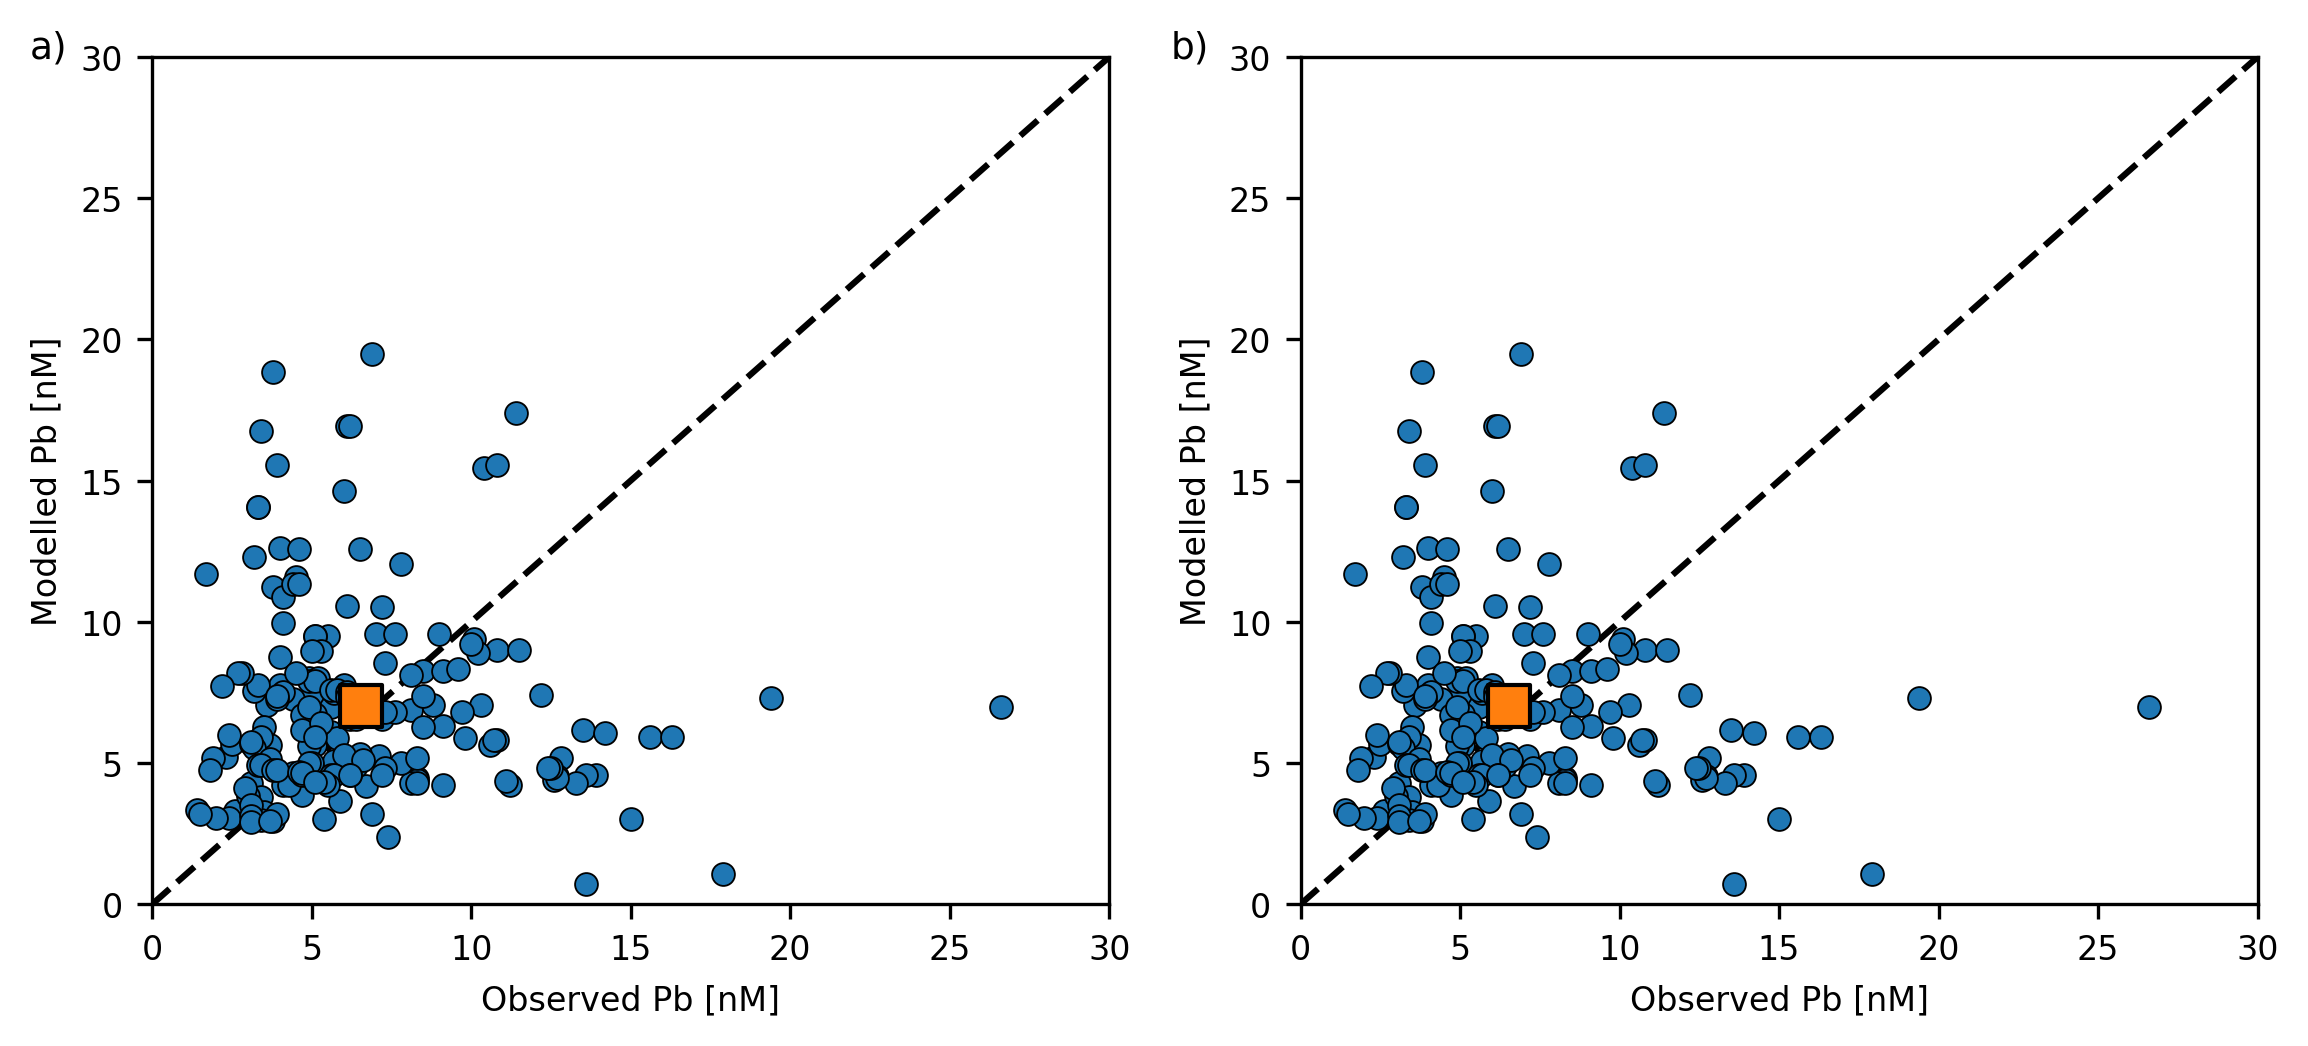

In [210]:
fig, ax = plt.subplots(1,2, figsize=(9.055, 3.74), dpi=300)
st = sns.axes_style("ticks")

with st:   
    for axis in ax:
        line1 = sns.lineplot(x=[0, 40],y=[0, 40], color='k', linewidth=1.5, zorder=1, ax=axis)
        line1.lines[0].set_linestyle('--')
        axis.set_xlabel('Observed Pb [nM]', fontsize=8)
        axis.set_ylabel('Modelled Pb [nM]',fontsize=8)
        axis.set(xlim=(0, 30.), ylim=(0, 30.))
        axis.tick_params(axis='both', which='major', labelsize=8) 

    ### Left plot ###
    sns.scatterplot(x=dpb_obs_collapse, y=dpb_model_collapse, s=30, \
                    edgecolor='k', zorder=2, ax=ax[0])
    sns.scatterplot(x=[np.nanmean(dpb_obs_collapse)],y=[np.nanmean(dpb_model_collapse)], s=100, linewidth=1.0, \
                    edgecolor='k', marker='s', zorder=3, ax=ax[0])
#     ax[0].legend(loc=(0.01, 0.86), frameon=False, fontsize=8)
    
    ### Right plot ###
    sns.scatterplot(x=dpb_obs_collapse, y=dpb_model_collapse, s=30, \
                    edgecolor='k', zorder=2, ax=ax[1])
    sns.scatterplot(x=[np.nanmean(dpb_obs_collapse)], y=[np.nanmean(dpb_model_collapse)], s=100, linewidth=1.0, \
                     edgecolor='k', marker='s', zorder=3, ax=ax[1])
#     ax[1].legend(loc=(0.01, 0.86), frameon=False, fontsize=8)
    
#-----------------------------------------------------------------------------------------------------------------------------------
### Full figure ###
fig.text(0.08, 0.88, 'a)', fontsize=9);
fig.text(0.50, 0.88, 'b)', fontsize=9);

# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/R3-model-vs-observations.jpg', \
#                bbox_inches='tight', dpi=300, transparent=True)
# fig.savefig('/ocean/brogalla/GEOTRACES/figures/paper1-202204/R3-model-vs-observations.svg', \
#                bbox_inches='tight', dpi=300, format='svg')